<hr>
<h1 style="font-size:48px"> CREDIT DECISION MODELING</h1>
This notebook develops multiple credit decisioning models based on machine learning methodologies and on the standard method for probability of default modeling, logistic regression. Given the small data frame available for model estimation, models are optimized up to a point with our goal being to showcase the capabilities of each methodology. The interpretability of various modeling approaches is examined by comparing the impact of credit enhancing strategies each loan applicant may implement. We find that machine learning methodologies are difficult to defend when applied to credit decisioning. On the other hand, machine learning and logistic regression are compared in terms of their economic performance. Our example showcases the impact of better statistical performance from machine learning models.
<hr>

### Modeling Approaches
**Machine Learning:**
- Decision Tree
- Gradient Boosting
- Random Forest
- Neural Net

**Standard Methodology:**
- Logistic Regression

Uses Free Dataset: German Credit. Continues EDA work in separate notebook.

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('germancredit.csv',header=0)

In [3]:
# Metadata
md = pd.read_csv('GermanCreditMetaData.csv',header=0,index_col='Code')
#md['Ord Meaning'] = md.index + ' ' + md.Meaning
#mdmap = md['Ord Meaning'].to_dict()

## Data Transformations

In [4]:
# Per Common Practice in Risk Models Estimate Propensity of Bad Credit (not Good)
df['bad'] = df.pop('GoodCredit') - 1

# New Feature: Age Group (Convert age13 to nominal)
# note: this might lead to loss of accuracy
#.      here it is accepted to improve interpretability
df['age_group'] =  pd.cut(df.age13,[18,25,30,50,60,90])

In [5]:
# Convert Nominal Variables to Numeric Using One-Hot Indicators
v_nominal = list(df.select_dtypes(include='O').columns)
nominal = v_nominal + ['age_group'] + ['installment8','residence11','liable18']

# select baseline levels for each nominal variable
baseline_level = ['checkingstatus1_A14', 'history3_A32', 'purpose4_A410', 
                  'savings6_A65', 'employ7_A75', 
                  'status9_A92', 'others10_A101', 'property12_A124', 
                  'otherplans14_A143', 'housing15_A152', 
                  'job17_A173', 'tele19_A191', 'foreign20_A201', 
                  'age_group_(60, 90]', 'installment8_4', 
                  'residence11_4', 'liable18_1']
df = pd.get_dummies(df, columns=nominal).drop(baseline_level,axis=1)
df.shape

(1000, 57)

## Model Data Frame

In [6]:
# list of predictors
predictors = df.drop('bad',axis=1).columns
print(*sorted(predictors),sep='\t')

age13	age_group_(18, 25]	age_group_(25, 30]	age_group_(30, 50]	age_group_(50, 60]	amount5	cards16	checkingstatus1_A11	checkingstatus1_A12	checkingstatus1_A13	duration2	employ7_A71	employ7_A72	employ7_A73	employ7_A74	foreign20_A202	history3_A30	history3_A31	history3_A33	history3_A34	housing15_A151	housing15_A153	installment8_1	installment8_2	installment8_3	job17_A171	job17_A172	job17_A174	liable18_2	otherplans14_A141	otherplans14_A142	others10_A102	others10_A103	property12_A121	property12_A122	property12_A123	purpose4_A40	purpose4_A41	purpose4_A42	purpose4_A43	purpose4_A44	purpose4_A45	purpose4_A46	purpose4_A48	purpose4_A49	residence11_1	residence11_2	residence11_3	savings6_A61	savings6_A62	savings6_A63	savings6_A64	status9_A91	status9_A93	status9_A94	tele19_A192


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df[predictors].values.astype("float64"), 
    df["bad"].values, 
    test_size=0.40, 
    random_state=19)


scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = scaler.transform(X_train)
X_test_std  = scaler.transform(X_test)

# Combine

X_std = np.concatenate([X_train_std, X_test_std])
y     = np.concatenate([y_train, y_test])

# MODEL DEVELOPMENT

In [8]:
from sklearn.metrics import roc_auc_score, classification_report

models = dict()

## MODEL: Decision Tree Classifier

In [9]:
from sklearn.tree import DecisionTreeClassifier

# Optimize Model By Selecting class_weight values
dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30,
                           min_impurity_decrease=.0001,
                           random_state=18, class_weight={1:1.0,0:0.1})
dt.fit(X_train, y_train);

models["Decision Tree"] = (dt,X_train,predictors)

In [10]:
print(classification_report(y_test,dt.predict(X_test)))
y_pred_dt = dt.predict_proba(X_test)[:, 1]
y_est_dt  = dt.predict_proba(X_train)[:, 1]

print('DTree Training AUC = {:.2%}       Validation AUC = {:.2%}'.format(
    roc_auc_score(y_train, y_est_dt),
    roc_auc_score(y_test, y_pred_dt)))

              precision    recall  f1-score   support

           0       0.95      0.14      0.24       281
           1       0.33      0.98      0.49       119

   micro avg       0.39      0.39      0.39       400
   macro avg       0.64      0.56      0.36       400
weighted avg       0.76      0.39      0.31       400

DTree Training AUC = 78.78%       Validation AUC = 74.16%


Predictors in Model 10

Feature Imporances (Top Predictors)


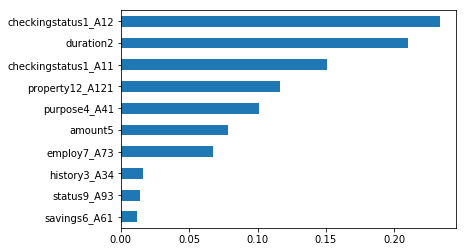

In [11]:
fi = pd.Series(dt.feature_importances_,index=predictors)
print('Predictors in Model',len(fi[fi>0]))
print('\nFeature Imporances (Top Predictors)')
_ = fi[fi>0.01].sort_values().plot.barh()

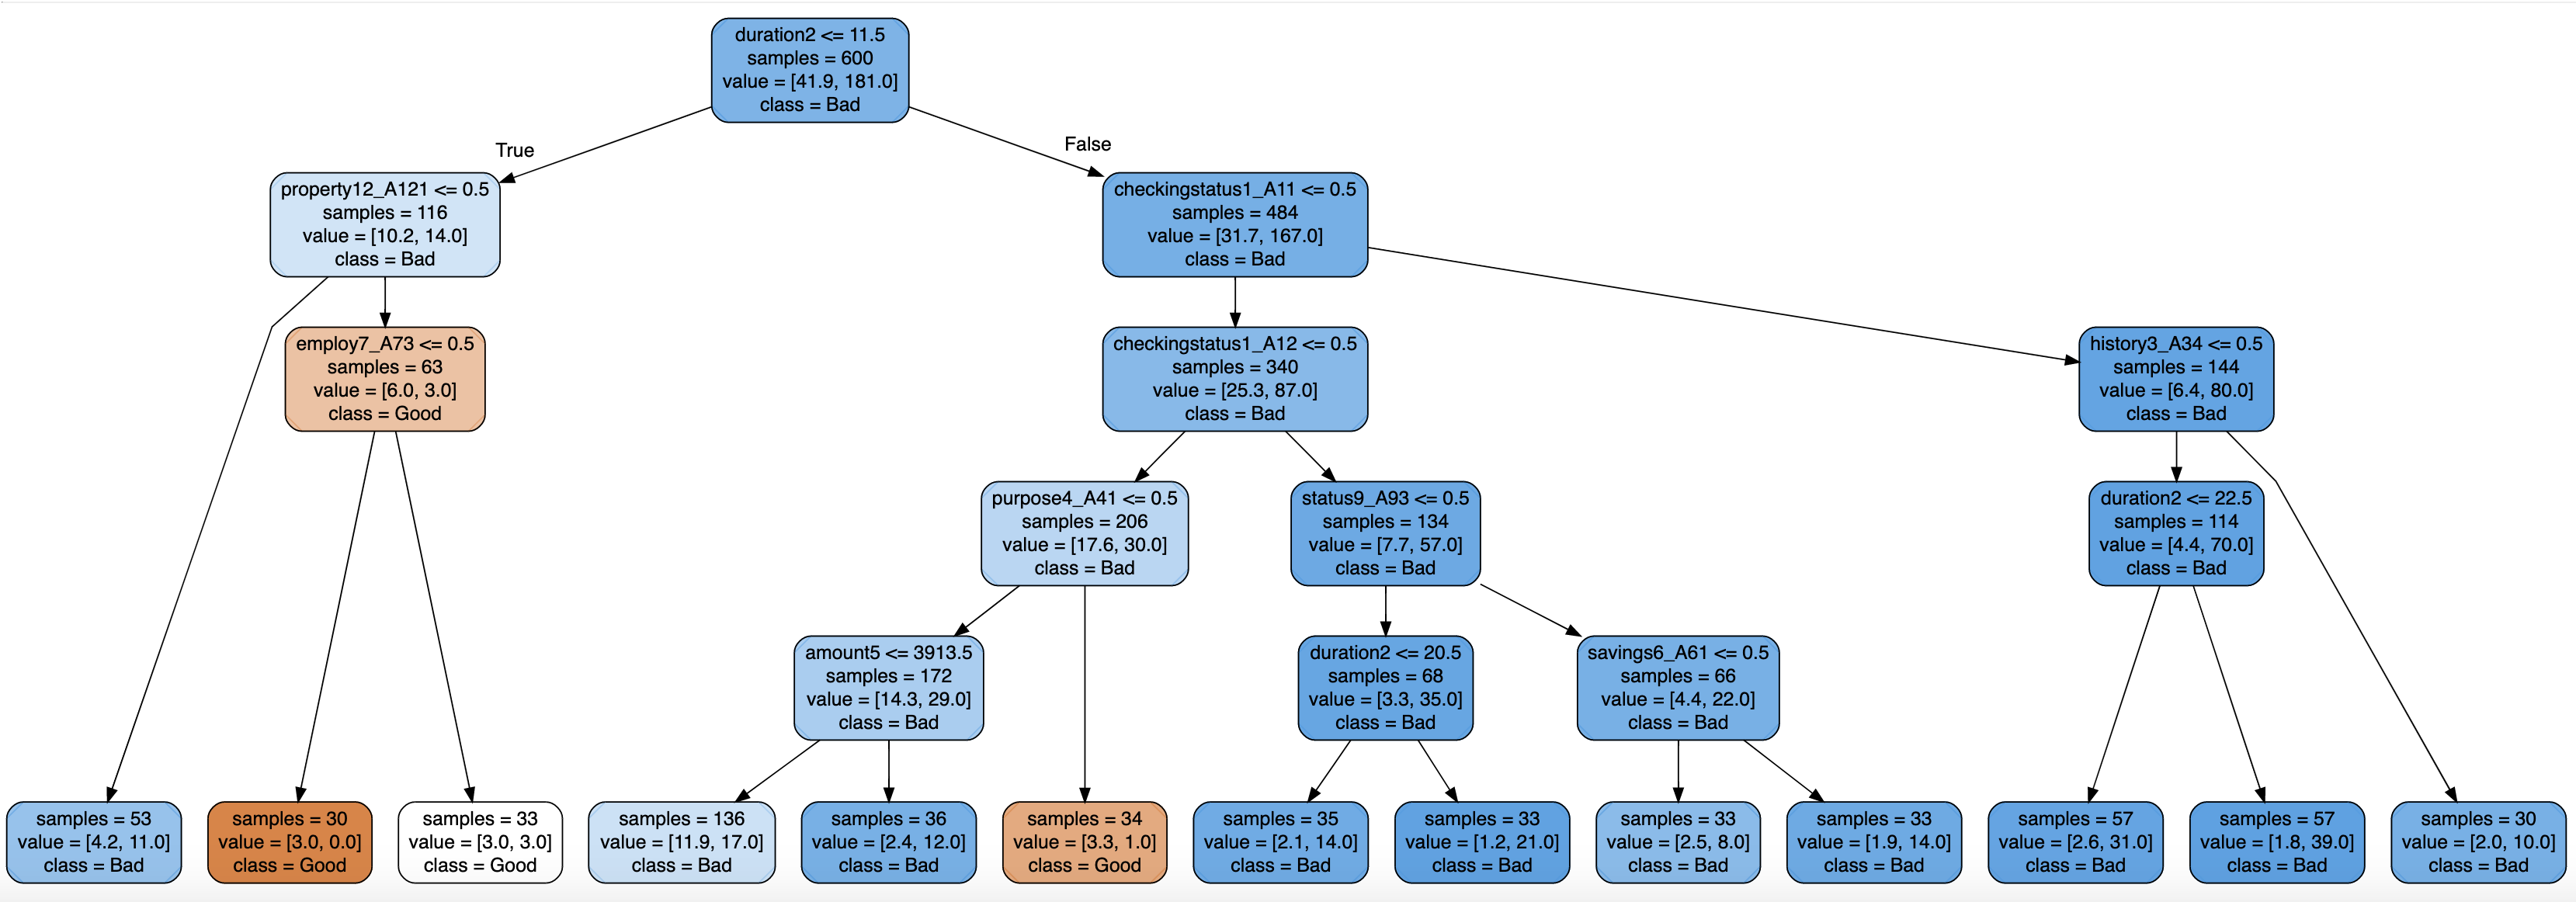

In [12]:
from sklearn.tree import export_graphviz
from IPython.display import Image

tree_graph = export_graphviz(dt,out_file=None,                              
    impurity = False,
    leaves_parallel=True,
    feature_names = predictors,
    class_names = ['Good', 'Bad'],
    rounded = True,
    filled= True )
#print(tree_graph)
Image("GermanCreditDTree.png")

In [13]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature ]

    def recurse(node, depth, index):
        indent = "    " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}{}) {} <= {} n={} {}".format(indent, index, name, threshold,
                tree_.n_node_samples[node],
                tree_.value[node] / tree_.weighted_n_node_samples[node]))
            recurse(tree_.children_left[node], depth + 1, 2*index+1)
            recurse(tree_.children_right[node], depth + 1, 2*index+2)
        else:
            print("{}{}) n={} {} *".format(indent, index, tree_.n_node_samples[node],
                 tree_.value[node] / tree_.weighted_n_node_samples[node]))

    recurse(0, 0, 0)

In [14]:
tree_to_code(dt,predictors)

0) duration2 <= 11.5 n=600 [[0.18797667 0.81202333]]
    1) property12_A121 <= 0.5 n=116 [[0.4214876 0.5785124]]
        3) n=53 [[0.27631579 0.72368421]] *
        4) employ7_A73 <= 0.5 n=63 [[0.66666667 0.33333333]]
            9) n=30 [[1. 0.]] *
            10) n=33 [[0.5 0.5]] *
    2) checkingstatus1_A11 <= 0.5 n=484 [[0.15953699 0.84046301]]
        5) checkingstatus1_A12 <= 0.5 n=340 [[0.2252894 0.7747106]]
            11) purpose4_A41 <= 0.5 n=206 [[0.3697479 0.6302521]]
                23) amount5 <= 3913.5 n=172 [[0.33025404 0.66974596]]
                    47) n=136 [[0.41176471 0.58823529]] *
                    48) n=36 [[0.16666667 0.83333333]] *
                24) n=34 [[0.76744186 0.23255814]] *
            12) status9_A93 <= 0.5 n=134 [[0.11901082 0.88098918]]
                25) duration2 <= 20.5 n=68 [[0.08616188 0.91383812]]
                    51) n=35 [[0.13043478 0.86956522]] *
                    52) n=33 [[0.05405405 0.94594595]] *
                26) savings

## MODEL: Gradient Boosting Tree

### Non Trivial Stump
Model comprised of elementary trees with long depth

In [15]:
from sklearn.ensemble import GradientBoostingClassifier

# optimize model by selecting max_depth, n_estimators, subsample, min_samples_leaf
grd = GradientBoostingClassifier(learning_rate=0.0003,
            n_estimators=9000, max_depth=10, subsample=.3, min_samples_leaf=3, random_state=18)
grd.fit(X_train, y_train);

models["Gradient Boosting NTS"] = (grd,X_train,predictors)

In [16]:
y_pred_grd = grd.predict_proba(X_test)[:, 1]
y_est_grd  = grd.predict_proba(X_train)[:, 1]

print(classification_report(y_test,grd.predict(X_test)))

print('GBM Training AUC = {:.2%}       Validation AUC = {:.2%}'.format(
    roc_auc_score(y_train, y_est_grd),
    roc_auc_score(y_test, y_pred_grd)))

              precision    recall  f1-score   support

           0       0.76      0.94      0.84       281
           1       0.67      0.29      0.40       119

   micro avg       0.74      0.74      0.74       400
   macro avg       0.71      0.61      0.62       400
weighted avg       0.73      0.74      0.71       400

GBM Training AUC = 99.55%       Validation AUC = 82.82%


Predictors in Model 56

Feature Imporances (Top Predictors)


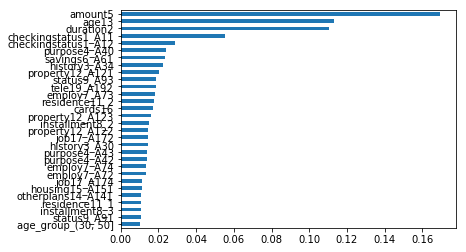

In [17]:
fi = pd.Series(grd.feature_importances_,index=predictors)
print('Predictors in Model',len(fi[fi>0]))
print('\nFeature Imporances (Top Predictors)')
_ = fi[fi>0.01].sort_values().plot.barh()

### Trivial Stump
Model comprised of elementary trees with depth equal to 1

In [18]:
# optimize model by selecting n_estimators, subsample, min_samples_leaf
grd2 = GradientBoostingClassifier(max_depth=1,learning_rate=0.002,
            n_estimators=10000, subsample=.4, min_samples_leaf=1,
                                 random_state=18)
grd2.fit(X_train, y_train);
models["Gradient Boosting TS"] = (grd2,X_train,predictors)

In [19]:
y_pred_grd2 = grd2.predict_proba(X_test)[:, 1]
y_est_grd2  = grd2.predict_proba(X_train)[:, 1]

print(classification_report(y_test,grd2.predict(X_test)))

print('GRD2   Training AUC = {:.2%}       Validation AUC = {:.2%}'.format(
    roc_auc_score(y_train, y_est_grd2),
    roc_auc_score(y_test, y_pred_grd2)))

              precision    recall  f1-score   support

           0       0.78      0.90      0.84       281
           1       0.63      0.40      0.49       119

   micro avg       0.75      0.75      0.75       400
   macro avg       0.71      0.65      0.66       400
weighted avg       0.74      0.75      0.73       400

GRD2   Training AUC = 84.59%       Validation AUC = 80.59%


Predictors in Model 54

Feature Imporances (Top Predictors)


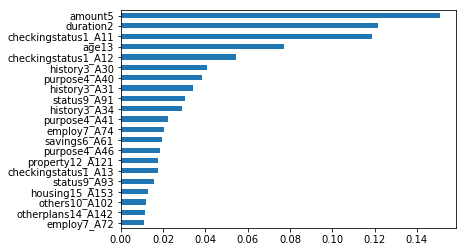

In [20]:
fi = pd.Series(grd2.feature_importances_,index=predictors)
print('Predictors in Model',len(fi[fi>0]))
print('\nFeature Imporances (Top Predictors)')
_ = fi[fi>0.01].sort_values().plot.barh()

## MODEL: Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier

# optimize model by selecting n_estimators, min_impurity_decrease, min_samples_leaf
rf = RandomForestClassifier(n_estimators=500, min_samples_leaf=3,
                           random_state=18, min_impurity_decrease=.00001)
rf.fit(X_train, y_train)

models["Random Forest"] = (rf,X_train,predictors)

In [22]:
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_est_rf  = rf.predict_proba(X_train)[:, 1]

print(classification_report(y_test,rf.predict(X_test)))

print('Random Forest Training AUC = {:.2%}       Validation AUC = {:.2%}'.format(
    roc_auc_score(y_train, y_est_rf),
    roc_auc_score(y_test, y_pred_rf)))

              precision    recall  f1-score   support

           0       0.75      0.95      0.84       281
           1       0.67      0.26      0.38       119

   micro avg       0.74      0.74      0.74       400
   macro avg       0.71      0.60      0.61       400
weighted avg       0.73      0.74      0.70       400

Random Forest Training AUC = 98.97%       Validation AUC = 82.05%


Predictors in Model 55

Feature Imporances (Top Predictors)


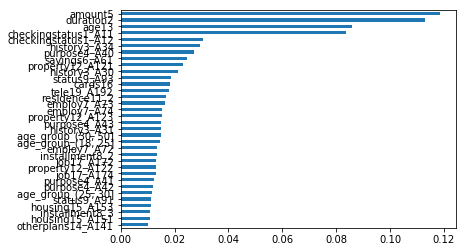

In [23]:
fi = pd.Series(rf.feature_importances_,index=predictors)
print('Predictors in Model',len(fi[fi>0.0]))
print('\nFeature Imporances (Top Predictors)')
_ = fi[fi>0.01].sort_values().plot.barh()

## MODEL: Neural Network (sklearn)
Estimate Using Cross-Validation

In [24]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits)

nnet_model = []
y_est  = []
y_pred = []

res = pd.DataFrame(index=np.arange(len(X_std)),
                  columns=['pred'] + ['est_{}'.format(i) for i in range(n_splits)])
res["pred"] = 0
for col in res.columns[1:]:
    res[col] = np.mean(y)

fold = 0
for train_i_, test_i_ in skf.split(X_std,y):
    X_trn, y_trn = X_std[train_i_], y[train_i_]
    X_oof, y_oof = X_std[test_i_],  y[test_i_]
    
    
    nnet = MLPClassifier(solver='adam', 
                         activation='logistic',
                         alpha=0.001, 
                         max_iter = 500,
                         learning_rate_init=.0002,
                         hidden_layer_sizes=(10,),
                         batch_size=8,
                         tol=1e-3,
                         random_state=18)

    nnet.fit(X_trn, y_trn)

    y_est_nnet  = nnet.predict_proba(X_trn)[:, 1]
    y_pred_nnet = nnet.predict_proba(X_oof)[:, 1]
    
    y_all_nnet  = nnet.predict_proba(X_std)[:, 1]
    res.iloc[train_i_,fold+1] = y_est_nnet
    res.iloc[test_i_,0] += y_pred_nnet / (n_splits-1)
    
    print('Neural Network (fold {:2}) Train AUC = {:.2%} OOF AUC = {:.2%}'.format(
        fold,
        roc_auc_score(y_trn, y_est_nnet),
        roc_auc_score(y_oof, y_pred_nnet)
        ))
    
    nnet_model.append((roc_auc_score(y_oof, y_pred_nnet),nnet))
    fold += 1
    
nnet_roc_auc, nnet = max(nnet_model)

Neural Network (fold  0) Train AUC = 83.63% OOF AUC = 80.52%
Neural Network (fold  1) Train AUC = 84.14% OOF AUC = 73.24%
Neural Network (fold  2) Train AUC = 82.89% OOF AUC = 87.71%
Neural Network (fold  3) Train AUC = 84.18% OOF AUC = 74.24%
Neural Network (fold  4) Train AUC = 84.75% OOF AUC = 72.71%
Neural Network (fold  5) Train AUC = 84.79% OOF AUC = 67.71%
Neural Network (fold  6) Train AUC = 84.34% OOF AUC = 73.62%
Neural Network (fold  7) Train AUC = 83.53% OOF AUC = 80.57%
Neural Network (fold  8) Train AUC = 82.88% OOF AUC = 87.76%
Neural Network (fold  9) Train AUC = 83.09% OOF AUC = 85.62%


In [25]:
models["Neural Net"] = (nnet,X_std,predictors)

In [26]:
print("OUT OF FOLD AUC = {:.2%}".format(roc_auc_score(y, res.pred)))

OUT OF FOLD AUC = 78.33%


Stacked Models R-sq 97.10%




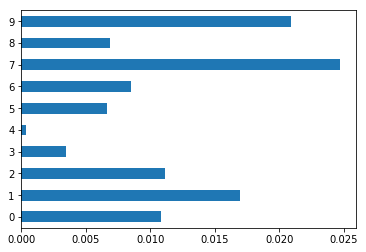

In [27]:
# Optimal Weights for Model Stacking
from sklearn.linear_model import LassoCV

stack = LassoCV(cv=5,normalize=True,positive=True,fit_intercept=False,max_iter=5000)

X_stack = np.array([m.predict_proba(X_std)[:, 1] for f,m in nnet_model]).T
stack.fit(X_stack,res['pred'])

pd.Series(stack.coef_).plot.barh()
print('Stacked Models R-sq {:.2%}\n\n'.format(stack.score(X_stack,res['pred'])))

## MODEL: Logistic Regression

### Logistic Regression: As if Machine Learning
Using LogisticRegressionCV

In [28]:
from sklearn.linear_model import LogisticRegressionCV

lrcv = LogisticRegressionCV(cv=3,class_weight="balanced",random_state=2019)

lrcv.fit(X_train_std,y_train)

y_est_lrcv  = lrcv.predict_proba(X_train_std)[:, 1]
y_pred_lrcv = lrcv.predict_proba(X_test_std)[:, 1]

print(classification_report(y_test,lrcv.predict(X_test_std)))

print('LOGIT CV    Training AUC = {:.2%}       Validation AUC = {:.2%}'.format(
    roc_auc_score(y_train, y_est_lrcv),
    roc_auc_score(y_test, y_pred_lrcv)))

              precision    recall  f1-score   support

           0       0.88      0.76      0.82       281
           1       0.57      0.75      0.65       119

   micro avg       0.76      0.76      0.76       400
   macro avg       0.72      0.75      0.73       400
weighted avg       0.79      0.76      0.77       400

LOGIT CV    Training AUC = 82.21%       Validation AUC = 81.12%


Largest Predictors in Model (24/56)


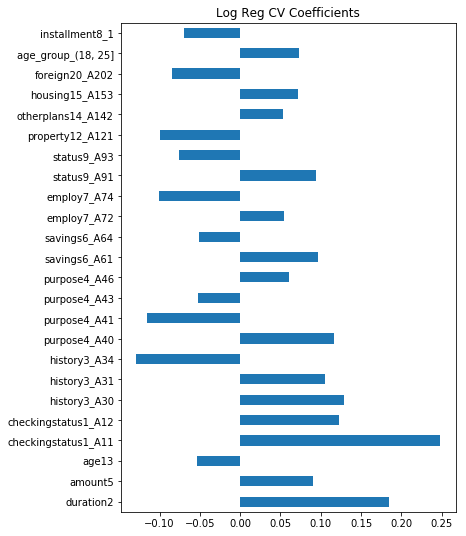

In [29]:
coef = pd.Series(lrcv.coef_.flatten(),index=predictors)
coef = coef[np.abs(coef)>0.05]

print('Largest Predictors in Model ({}/{})'.format(len(coef),len(predictors)))

_ = coef.plot.barh(figsize=(6,9), title="Log Reg CV Coefficients")

*Problem:* Model uses restricted predictors: age13 and foreign20

### Logistic Regression: Variables Selected According to Theory and Previous Practice

In [30]:
scvars = ['savings6', 'property12', 'amount5', 'checkingstatus1', 'duration2', 'history3', 'purpose4', 
          'employ7', 'installment8']
scvars_select = [i for i,p in enumerate(predictors) if  any(v in p for v in scvars)]

In [31]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=0.02, solver="lbfgs", 
                            class_weight="balanced", random_state=2019) # Using optimal C-value
# IMPORTANT: Using Scaled Data
X_train_lr = X_train_std[:,scvars_select]
X_test_lr  = X_test_std[:,scvars_select]

logreg.fit(X_train_lr,y_train);

models["Logistic Regression"] = (logreg,X_train_lr,predictors[scvars_select])

In [32]:
y_est_prob  = logreg.predict_proba(X_train_lr)[:, 1]
y_pred_prob = logreg.predict_proba(X_test_lr)[:, 1]
print('LOGIT Training AUC = {:.2%}       Validation AUC = {:.2%}'.format(
        roc_auc_score(y_train, y_est_prob),
        roc_auc_score(y_test, y_pred_prob)))

LOGIT Training AUC = 80.93%       Validation AUC = 79.51%


In [33]:
coef = pd.Series(logreg.coef_.flatten(),index=predictors[scvars_select])

In [34]:
varinfo = [name.split("_") if "_" in name else (name,"num") for name in coef.index]
varinfo = [(var,"A8"+info+"_level is "+info if var=="installment8" else info) for var, info in varinfo]

varinfo = [(re.sub(r"\D+","",var),var) + ((info,md.loc[info,"Meaning"]) if info in md.index 
                                          else ("num","") if info=="num" else tuple(info.split("_")))
           for var, info in varinfo]
varinfo = [(int(o), var, key, info) for o, var, key, info in varinfo]

In [35]:
coef.index = pd.MultiIndex.from_tuples(varinfo, names=["Index","Predictor","Key","Meaning"])

In [36]:
print('\nLog Reg Coefficients')
out = coef.sort_index().rename('coeff').to_frame().reset_index()
out.style.bar(subset="coeff",align='mid',color=['lightblue','pink']).hide_index()


Log Reg Coefficients


Index,Predictor,Key,Meaning,coeff
1,checkingstatus1,A11,... < 0 DM,0.460429
1,checkingstatus1,A12,0 <= ... < 200 DM,0.289294
1,checkingstatus1,A13,... >= 200 DM / salary assignments for at least 1 year,0.105075
2,duration2,num,,0.315541
3,history3,A30,no credits taken/ all credits paid back duly,0.160899
3,history3,A31,all credits at this bank paid back duly,0.159141
3,history3,A33,delay in paying off in the past,-0.0486213
3,history3,A34,critical account/ other credits existing (not at this bank),-0.222144
4,purpose4,A40,car (new),0.185117
4,purpose4,A41,car (used),-0.191586


<hr>
<h1>Perturbation Analysis</h1>
<hr>

In [37]:
def prob2logit(p):
    "Probability to Log Odds"
    return np.log((1-p)/p)

def plot_logodds_diff(ax,logodds0,logodds1,var,var_from,var_to,cmark='b.'):
    ax.text(0.5,1.06, "LodOdds Difference for "+var, ha="center", transform=ax.transAxes)
    ax.plot(logodds0,(logodds1-logodds0),cmark)
    ax.grid()
    ax.set_xlabel("LogOdds {} = {}".format(var,var_from),alpha=0.6)
    ax.set_ylabel("LogOdds Diff {}\nfrom value={} to value={}".format(var,var_from,var_to),alpha=0.6)
    ax.text(0.5,-0.25, "Average LogOdds Difference: {:.3f}\n\n".format(np.nanmean(logodds1-logodds0)), 
            ha="center", transform=ax.transAxes)

def perturb(model,X,pred,model_name,a0=0,a1=1):
    """
    Estimate <model> Having Predictors <pred> Using data <X> Varying <property12> or <checkingstatus1_A11> from value <a0> to value <a1>
    Plot Result
    """
    
    pred = list(pred)
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5), sharex=True, sharey=True)
    fig.suptitle(model_name.upper(), fontsize=18)

    # property12
    
    cs1_col = pred.index("property12_A121")
    cs2_col = pred.index("property12_A122")
    cs3_col = pred.index("property12_A123")
        
    # scenario 0 has property12_A124 (no property)
    X_ = X.copy()
    X_[:,cs1_col] = X[:,cs1_col].min()
    X_[:,cs2_col] = X[:,cs2_col].min()
    X_[:,cs3_col] = X[:,cs3_col].min()
    p_hat = model.predict_proba(X_)[:,1]
    logodds0 = prob2logit(np.where(p_hat>1e-6,p_hat,np.nan))

    
    # scenario 1 has property12_A121 (real estate)
    X_ = X.copy()
    X_[:,cs1_col] = X[:,cs1_col].max()
    X_[:,cs2_col] = X[:,cs2_col].min()
    X_[:,cs3_col] = X[:,cs3_col].min()
    p_hat = model.predict_proba(X_)[:,1]
    logodds1 = prob2logit(np.where(p_hat>1e-6,p_hat,np.nan))

    plot_logodds_diff(ax1,logodds0,logodds1,"property12","A124","A121")


    
    # checkingstatus1
    
    cs1_col = pred.index("checkingstatus1_A11")
    cs2_col = pred.index("checkingstatus1_A12")
    cs3_col = pred.index("checkingstatus1_A13")
        
    # scenario 0 has checkingstatus1_A11
    X_ = X.copy()
    X_[:,cs1_col] = X[:,cs1_col].max()
    X_[:,cs2_col] = X[:,cs2_col].min()
    X_[:,cs3_col] = X[:,cs3_col].min()
    p_hat = model.predict_proba(X_)[:,1]
    logodds0 = prob2logit(np.where(p_hat>1e-6,p_hat,np.nan))

    
    # scenario 1 has checkingstatus1_A12
    X_ = X.copy()
    X_[:,cs1_col] = X[:,cs1_col].min()
    X_[:,cs2_col] = X[:,cs2_col].max()
    X_[:,cs3_col] = X[:,cs3_col].min()
    p_hat = model.predict_proba(X_)[:,1]
    logodds1 = prob2logit(np.where(p_hat>1e-6,p_hat,np.nan))

    plot_logodds_diff(ax2,logodds0,logodds1,"checkingstatus1","A11","A12","g.")
    plt.show()

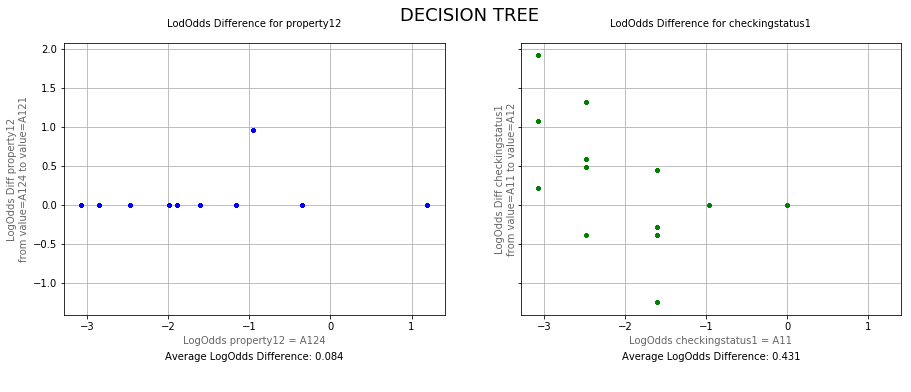

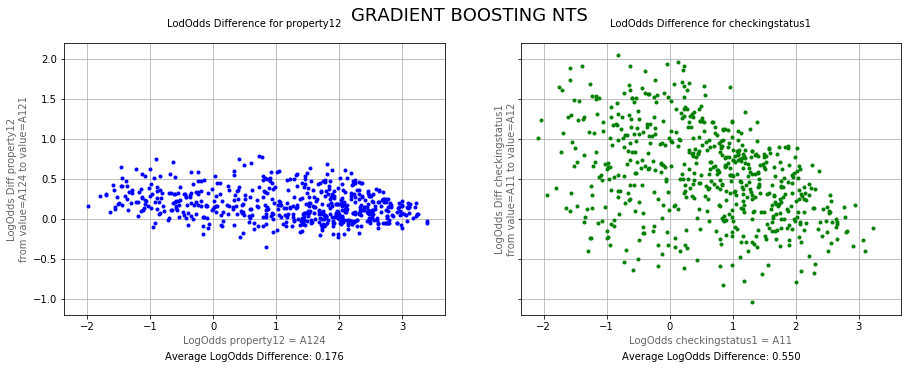

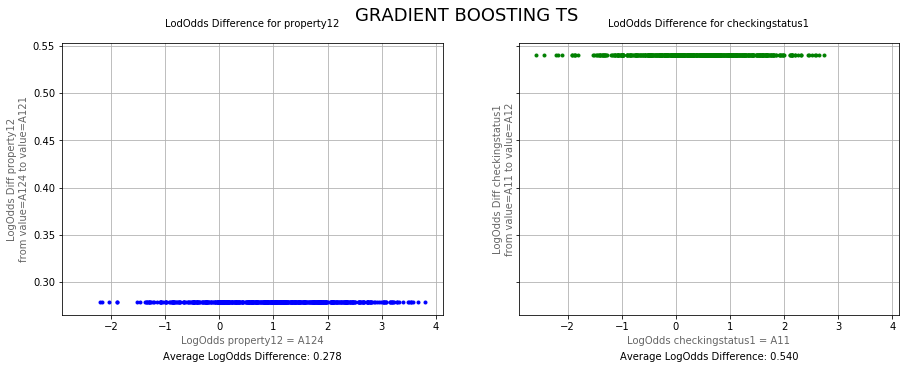

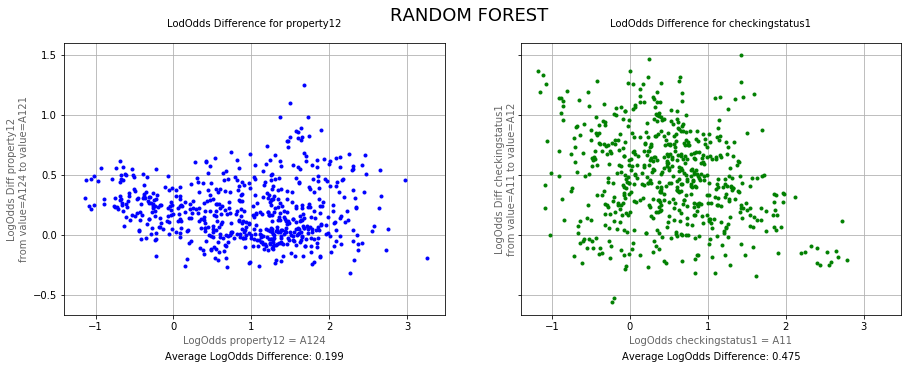

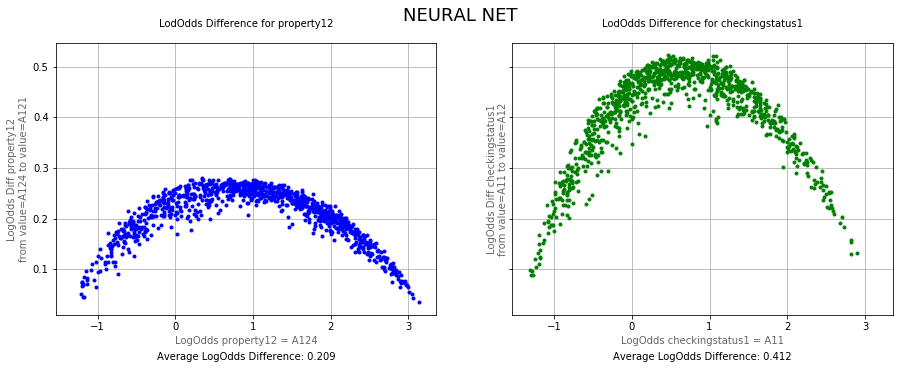

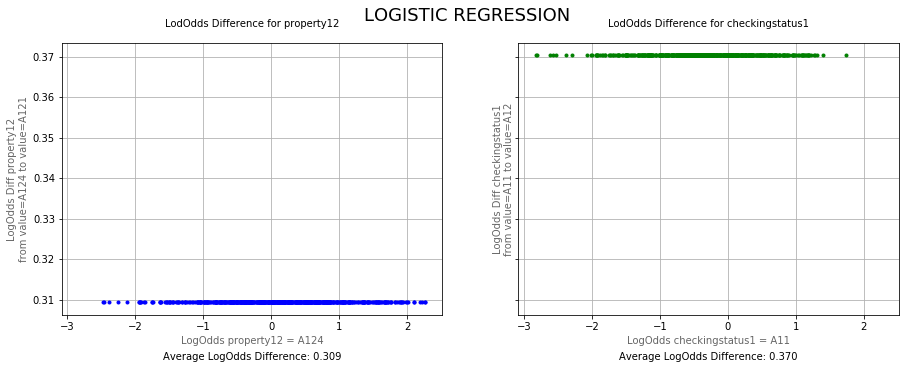

In [38]:
for modname in models:
    perturb(*models[modname],model_name=modname)
    print("\n\n")

# Compare Performance

In [39]:
def perf(y_est,y,delinq_reduce=0.50,revenue_loss=0.30):
    n = len(y)
    bad_total = np.sum(y)
    df = pd.DataFrame({'prob':y_est,'bad':y,'decile':pd.qcut(y_est,10)})
    out = df.groupby('decile').bad.aggregate(['mean','sum','size'])
    out.columns = ["default risk","exp bad","group size"]
    display(out)
    
    df = df.sort_values(by='prob')
    df['cum_bad_pct'] = df.bad.cumsum() / bad_total
    low_delinq_revenue = len(df[df.cum_bad_pct < (1 - delinq_reduce)])/n
    high_rev_delinq = df.iloc[:int(n*(1.-revenue_loss))].bad.sum() / bad_total
    
    #print('Current Revenue = {:.2%}, Current Delinquency = {:.2%}'.format(1.0, bad_total/n))
    print('Max Revenue While Delinquency is Reduced by {:.2%} = {:.2%}'.format(delinq_reduce,low_delinq_revenue))
    
    print('Max Delinquency Reduction If Revenue is Reduced by {:.2%} = {:.2%}'.format(
        revenue_loss,1-high_rev_delinq))
    return (1,bad_total/n,delinq_reduce,low_delinq_revenue,revenue_loss,high_rev_delinq)

In [40]:
print("Logistic Regression")
y_pred_prob = logreg.predict_proba(X_test_lr)[:, 1]
tmp = perf(y_pred_prob,y_test)

Logistic Regression


,default risk,exp bad,group size
decile,,,
"(0.07629999999999999, 0.214]",0.025,1,40
"(0.214, 0.264]",0.050,2,40
"(0.264, 0.325]",0.175,7,40
"(0.325, 0.382]",0.050,2,40
"(0.382, 0.434]",0.150,6,40
"(0.434, 0.515]",0.350,14,40
"(0.515, 0.578]",0.525,21,40
"(0.578, 0.659]",0.425,17,40
"(0.659, 0.74]",0.525,21,40


Max Revenue While Delinquency is Reduced by 50.00% = 74.25%
Max Delinquency Reduction If Revenue is Reduced by 30.00% = 55.46%


In [41]:
print('Machine Learning (Gradient Boosting - Not Simple)')
tmp = perf(y_pred_grd,y_test)

Machine Learning (Gradient Boosting - Not Simple)


,default risk,exp bad,group size
decile,,,
"(0.032, 0.0746]",0.000,0,40
"(0.0746, 0.0975]",0.025,1,40
"(0.0975, 0.122]",0.100,4,40
"(0.122, 0.171]",0.100,4,40
"(0.171, 0.205]",0.125,5,40
"(0.205, 0.27]",0.350,14,40
"(0.27, 0.348]",0.375,15,40
"(0.348, 0.442]",0.625,25,40
"(0.442, 0.563]",0.575,23,40


Max Revenue While Delinquency is Reduced by 50.00% = 76.00%
Max Delinquency Reduction If Revenue is Reduced by 30.00% = 63.87%


### - Prepare Data for Optimization Study

In [42]:
df["risk"] = grd2.predict_proba(df[predictors].values.astype("float64"))[:,1]

In [43]:
df.to_csv("germancredit_out.csv",index=False)

<hr>
**End of Notebook**